# 1. Байесовский и классический подходы

Здесь мы сравним два подхода для расчёта доверительных интервалов: частотный и байесовский.

$\bar{X}$ -- среднее выборки, $s^2$ -- дисперсия выборки.

Частотный(frequentistic) интервал:

$$C_n = \bar{X} \pm t_{n-1} \frac{s}{\sqrt{n}}$$

Байесовский(bayesian) интервал:

$$C_n = \mu_{bayes} \pm t_{n-1} \sigma_{bayes}$$

где,

$$\mu_{bayes} = \frac{1 / \sigma_0^2}{n / s^2 + 1 / \sigma_0^2} \mu_0 + \frac{n / s^2}{n / s^2 + 1 / \sigma_0^2} \bar{X}$$

$$\sigma^2_{bayes} = \frac{s^2 \sigma_0^2}{s^2 + n \sigma_0^2},$$

где, $\mu_0$ и $\sigma_0$ -- априорное знание.

Сравниваться мы будем на 3х распределениях: 
  * стандартном нормальном;
  * экспоненциальном с $\lambda=2$; 
  * бета-распределением с $a=2,~~b=5$.
  
Кроме того, мы будем варьировать $\mu_0$:
  * $\mu_0 = \mu$ -- точное попадание в цель;
  * $\mu_0 = \mu + 0.25 s$ -- наши приоры имеют смещение;
  * $\mu_0 = \mu + 0.5 s$ -- наши приоры имеют __сильное__ смещение;
  
  
$$\sigma_0^2 = \frac{s^2}{12}$$

#### Цитата:

![](prior_sigma.png)

https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2027&context=jmasm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon, beta
%matplotlib inline

sns.set(font_scale=2)

In [2]:
from scipy.stats import t
def calc_intervals(distr, bias=0, q=0.95, n=100, true_mean=0):
    X = distr.rvs(size=n)
    X_mean = X.mean()
    X_std = np.std(X, ddof=1)
    t_n_1 = t(df=n - 1).ppf(1 - (1 - q) / 2)
    
    freq_lower_bound, freq_higher_bound = X_mean - t_n_1 * X_std / np.sqrt(n), X_mean + t_n_1 * X_std / np.sqrt(n) 
    
    X_mean_prior = true_mean + ([-1, 1][np.random.randint(2)]) * bias * X_std
    X_std_prior = X_std / np.sqrt(12)
    
    X_mean_bayes = X_mean * (n / X_std**2) / ( n / X_std**2 + 1 / X_std_prior**2 ) + X_mean_prior * (1 / X_std_prior**2) / ( n / X_std**2 + 1 / X_std_prior**2 )
    X_std_bayes = np.sqrt((X_std**2 * X_std_prior**2) / (X_std**2 + n * X_std_prior**2))
    bayes_lower_bound, bayes_higher_bound = X_mean_bayes - t_n_1 * X_std_bayes, X_mean_bayes + t_n_1 * X_std_bayes
    
    return freq_lower_bound, freq_higher_bound, \
           bayes_lower_bound, bayes_higher_bound, \
           (X_mean - true_mean)**2, (X_mean_bayes - true_mean)**2

In [3]:
ns = np.arange(10, 110, 10)

In [4]:
experiments = 1000

In [5]:
def run_stats(ns, distr, experiments=100, true_mean=0, bias=0):
    freq_capture_rates = []
    bayes_capture_rates = []
    mse_bayeses = []
    mse_freqs = []
    for n in ns:
        freq_capture_rate = 0
        bayes_capture_rate = 0
        mse_bayes = 0
        mse_freq = 0
        for _ in range(experiments):
            freq_lower_bound, freq_higher_bound, \
            bayes_lower_bound, bayes_higher_bound, \
            mse_f, mse_b = calc_intervals(distr=distr, bias=bias, n=n, true_mean=true_mean)
            
            freq_capture_rate += (freq_lower_bound < true_mean < freq_higher_bound)
            bayes_capture_rate += (bayes_lower_bound < true_mean < bayes_higher_bound)
            mse_bayes += mse_b # (var_bayes + bias**2)
            mse_freq += mse_f # var_freq
            
        mse_bayeses.append(mse_bayes / experiments)
        mse_freqs.append(mse_freq / experiments)
        freq_capture_rates.append(freq_capture_rate / experiments)
        bayes_capture_rates.append(bayes_capture_rate / experiments)
    return mse_bayeses, mse_freqs, freq_capture_rates, bayes_capture_rates

In [6]:
def draw_comparison(distr, true_mean):
    mse_bayeses, mse_freqs, freq_capture_rates, bayes_capture_rates = run_stats(ns, distr=distr, 
                                                                                true_mean=true_mean, bias=0.0,
                                                                                experiments=experiments)
    freq_capture_rates = np.array(freq_capture_rates)
    bayes_capture_rates = np.array(bayes_capture_rates)
    mse_bayeses = np.array(mse_bayeses)
    mse_freqs = np.array(mse_freqs)

    mse_bayeses_low_bias, _, _, bayes_capture_rates_low_bias = run_stats(ns, distr=distr, 
                                                                         true_mean=true_mean, bias=0.25, 
                                                                         experiments=experiments)
    mse_bayeses_low_bias = np.array(mse_bayeses_low_bias)
    bayes_capture_rates_low_bias = np.array(bayes_capture_rates_low_bias)

    mse_bayeses_high_bias, _, _, bayes_capture_rates_high_bias = run_stats(ns, distr=distr, 
                                                                           true_mean=true_mean, bias=0.5, 
                                                                           experiments=experiments)
    mse_bayeses_high_bias = np.array(mse_bayeses_high_bias)
    bayes_capture_rates_high_bias = np.array(bayes_capture_rates_high_bias)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    # fig.suptitle('{} distribution. N={}, B={}'.format(distr.dist.name, N, B))
    axes[0].plot(ns, mse_freqs, label='Frequentist')
    axes[0].plot(ns, mse_bayeses, label='Bayes. No bias.')
    axes[0].plot(ns, mse_bayeses_low_bias, label='Bayes. Low bias.')
    axes[0].plot(ns, mse_bayeses_high_bias, label='Bayes. High bias.')
    axes[1].set_title('MSE')
    axes[0].legend()

    axes[1].plot(ns, freq_capture_rates, label='Frequentist')
    freq_capture_rates_std = np.sqrt(freq_capture_rates * (1 - freq_capture_rates) / experiments)
    axes[1].fill_between(ns, freq_capture_rates - freq_capture_rates_std, freq_capture_rates + freq_capture_rates_std, 
                         alpha=0.3)


    axes[1].plot(ns, bayes_capture_rates, label='Bayes. No bias.')
    bayes_capture_rates_std = np.sqrt(bayes_capture_rates * (1 - bayes_capture_rates) / experiments)
    axes[1].fill_between(ns, bayes_capture_rates - bayes_capture_rates_std, bayes_capture_rates + bayes_capture_rates_std, 
                         alpha=0.3)

    axes[1].plot(ns, bayes_capture_rates_low_bias, label='Bayes. Low bias.')
    bayes_capture_rates_low_bias_std = np.sqrt(bayes_capture_rates_low_bias * (1 - bayes_capture_rates_low_bias) / experiments)
    axes[1].fill_between(ns, bayes_capture_rates_low_bias - bayes_capture_rates_low_bias_std, bayes_capture_rates_low_bias + bayes_capture_rates_low_bias_std, 
                         alpha=0.3)


    axes[1].plot(ns, bayes_capture_rates_high_bias, label='Bayes. High bias.')
    bayes_capture_rates_high_bias_std = np.sqrt(bayes_capture_rates_high_bias * (1 - bayes_capture_rates_high_bias) / experiments)
    axes[1].fill_between(ns, bayes_capture_rates_high_bias - bayes_capture_rates_high_bias_std, bayes_capture_rates_high_bias + bayes_capture_rates_high_bias_std, 
                         alpha=0.3)
    axes[1].axhline(y=0.95, color='r', linestyle='-')
    axes[1].set_title('Capture rate')
    axes[1].legend()

### Стандартное нормальное распределение

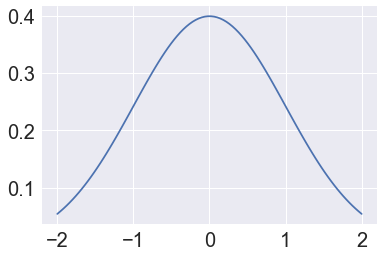

In [7]:
x = np.linspace(-2, 2, 100)
plt.plot(x, (norm().pdf(x)))

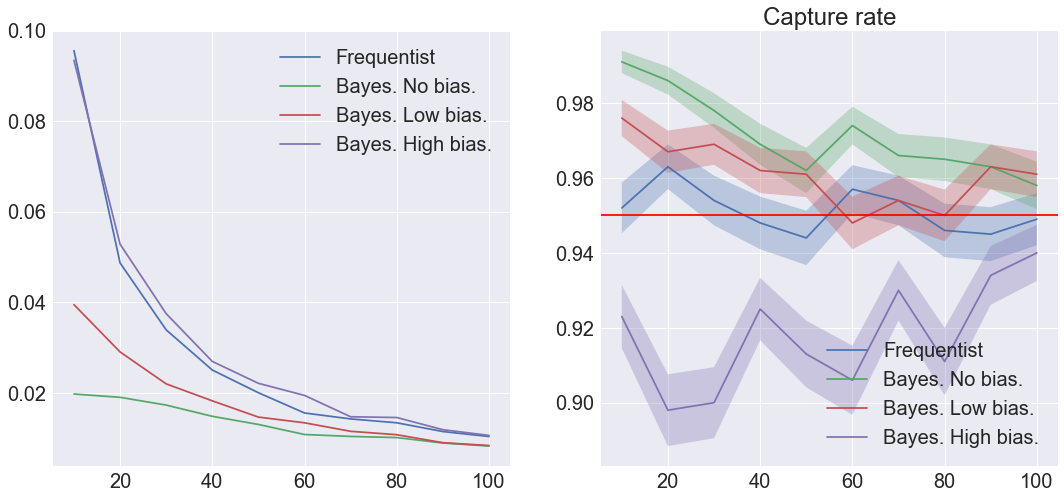

In [8]:
draw_comparison(norm(), 0)

### Экспоненциальное распределение

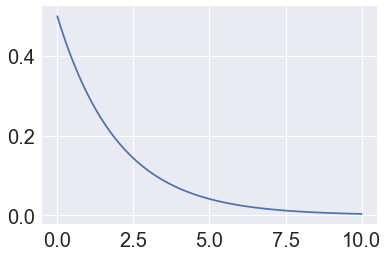

In [9]:
x = np.linspace(0, 10, 100)
plt.plot(x, (expon(scale=2).pdf(x)))

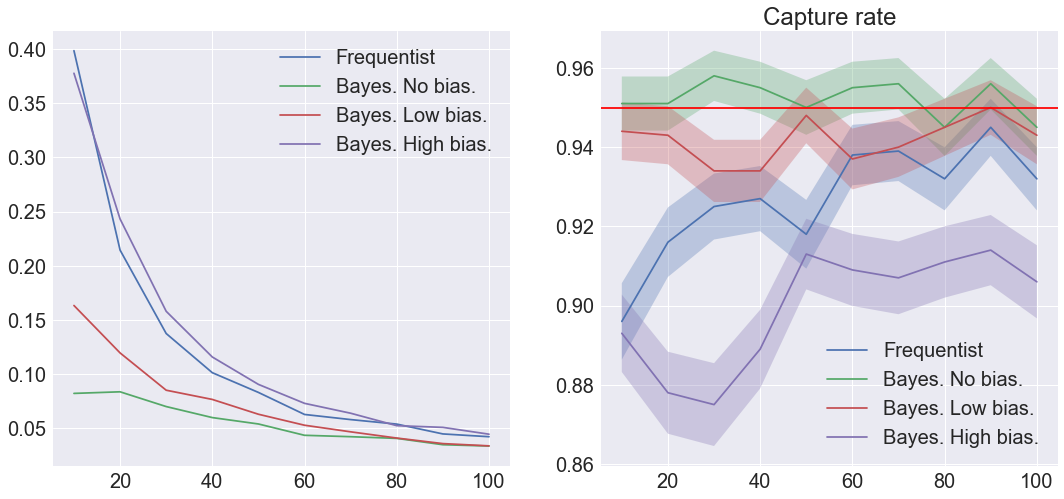

In [10]:
draw_comparison(expon(scale=2), 2)

### Бета распределение

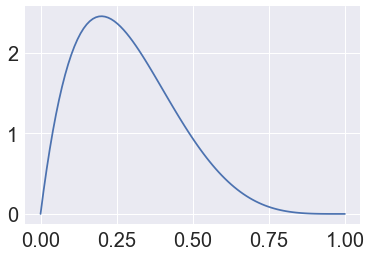

In [11]:
x = np.linspace(0, 1, 100)
plt.plot(x, (beta(a=2, b=5).pdf(x)))

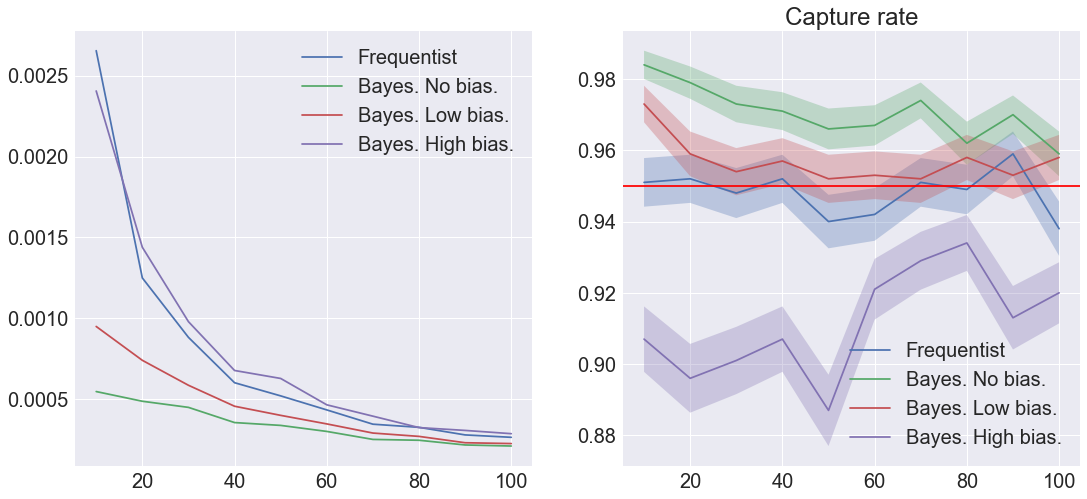

In [12]:
draw_comparison(beta(a=2, b=5), 2 / (2 + 5))

#### Вывод

Байесовские интервалы показывают более хорошее покрытие в сравнении с частотным подходом в случае когда ошибка в априорном значении величины не превышает $\sim 0.25-0.5$ стандартных отклонений.

Поэтому если есть хорошие основания для задания априорных значений величин, то следует предпочесть байесовские интервалы.

# 2. Сравнение  4 типов интервалов

### Оценка доверительного интервала

Будем говорить про оценку среднего, т.е. $\theta = \mu$.

Обозначения:

$$\hat{\theta} = \bar{X}$$

$$\hat{se} = \mathrm{Var}[{X}]$$

$\hat{\theta}^{\alpha}$ -- перцентиль посчитанная по бутстрапной выборке.

##### $1 - 2 \alpha$ центральный интервал:

$$C_n = 2 \hat{\theta} - \hat{\theta}^{(1 - \alpha)}, 2 \hat{\theta} - \hat{\theta}^{(\alpha)}$$


##### $1 - 2 \alpha$ нормальный интервал:

$$C_n = \hat{\theta} + z_{\alpha}v_{boot}, \hat{\theta} + z_{1 - \alpha}v_{boot}$$


##### $1 - 2 \alpha$ перцентильный интервал:

$$C_n = \hat{\theta}^{(\alpha)}, \hat{\theta}^{(1 - \alpha)}$$

##### $1 - 2 \alpha$ bootstrap-t интервал:


Bootstrap-t оценивается по-другому:

$$C_n = \left( \hat{\theta} - \hat{se} \cdot \hat{t}^{(1 - \alpha)}, \hat{\theta} - \hat{se} \cdot \hat{t}^{(\alpha)} \right),$$

где квантили $t$ считаются от следующих оценок по бутстрапным выборкам:

$$t^*(b) = \frac{\hat{\theta}^*(b) - \hat{\theta}}{\hat{se}^*(b)}$$

Мы сравним все 4 метода оценивания интервалов на 4х примерах.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(font_scale=2)

In [14]:
from scipy.stats import cauchy, norm, t, expon, beta

def mean(X):
    return np.mean(X, axis=1)

def mean_t(X, X_original):
    return (np.mean(X, axis=1) - np.mean(X_original)) / np.std(X, axis=1)

def percentile_confidence_interval(X, q=5):
    return np.percentile(X, q=q / 2), np.percentile(X, q=100 - q / 2)

In [15]:
CAPTURE_RATE_NUM = 200

def calculate_intervals(distr):
    X = distr.rvs(size=N)
    boots = np.random.choice(X, (B, N), replace=True)
    mean_boots = mean(boots)
    mean_boots_t = mean_t(boots, X)
    X_std = X.std()
    X_mean = X.mean()
    X_boot_std = np.sqrt(np.sum((mean_boots - X_mean)**2 / (len(mean_boots) - 1)))
    limits = [X_mean + X_boot_std * norm.ppf(0.0001), X_mean + X_boot_std * norm.ppf(.9999)]
    lower_interval_normal, higher_interval_normal = X_mean + X_boot_std * norm.ppf(0.025), X_mean + X_boot_std * norm.ppf(.975)

    lower_interval_percentile, higher_interval_percentile = percentile_confidence_interval(mean_boots)
    
    higher_interval_t, lower_interval_t = percentile_confidence_interval(mean_boots_t)
    lower_interval_t = X.mean() - X_std * lower_interval_t
    higher_interval_t = X.mean() - X_std * higher_interval_t
    
    higher_interval_central, lower_interval_central = percentile_confidence_interval(mean_boots)
    lower_interval_central = X_mean * 2 - lower_interval_central; higher_interval_central = X_mean * 2 - higher_interval_central
    return X, X_mean, X_std, X_boot_std, mean_boots, lower_interval_normal, higher_interval_normal, lower_interval_percentile, higher_interval_percentile, \
           lower_interval_t, higher_interval_t, lower_interval_central, higher_interval_central

def plot_statistics(distr, true_mean=0):
    X, X_mean, X_std, X_boot_std, mean_boots, lower_interval_normal, higher_interval_normal, lower_interval_percentile, higher_interval_percentile, \
           lower_interval_t, higher_interval_t, lower_interval_central, higher_interval_central = calculate_intervals(distr)
    limits = [X_mean + X_boot_std * norm.ppf(0.0001), X_mean + X_boot_std * norm.ppf(.9999)]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
    fig.suptitle('{} distribution. N={}, B={}'.format(distr.dist.name, N, B))
    axes[0][0].hist(X, bins=100, density=True);
    axes[0][0].axvline(x=X_mean, linewidth=4, color='r')
    axes[0][0].set_xlim(np.percentile(X, 2), np.percentile(X, 98))
    axes[0][0].set_title('Sample')
    
    axes[0][1].hist(mean_boots, bins=100, density=True);
    axes[0][1].axvline(x=lower_interval_percentile, linewidth=1, 
                    color='r', linestyle='--')
    axes[0][1].axvline(x=higher_interval_percentile, linewidth=1, 
                    color='r', linestyle='--', label='Percentile bootstrap interval')


    axes[0][1].axvline(x=lower_interval_t, linewidth=1, 
                    color='g', linestyle='-', label='t-bootstrap interval')
    axes[0][1].axvline(x=higher_interval_t, linewidth=1, 
                    color='g', linestyle='-')
    
    axes[0][1].axvline(x=lower_interval_central, linewidth=1, 
                    color='b', linestyle='-')
    axes[0][1].axvline(x=higher_interval_central, linewidth=1, 
                    color='b', linestyle='-', label='central interval')
    
    axes[0][1].axvline(x=lower_interval_normal, linewidth=1, 
                    color='k', linestyle='-')
    axes[0][1].axvline(x=higher_interval_normal, linewidth=1, 
                    color='k', linestyle='-', label='normal interval')
    axes[0][1].set_xlim(limits)
    axes[0][1].set_title('Example')
    axes[0][1].legend()
    
    # compute capture rate and mse
    capture_rate_percentile, capture_rate_t, capture_rate_central, capture_rate_normal = 0, 0, 0, 0
    lower_intervals_percentile, lower_intervals_t, lower_intervals_central, lower_intervals_normal = [], [], [], []
    higher_intervals_percentile, higher_intervals_t, higher_intervals_central, higher_intervals_normal = [], [], [], []
    for i in range(CAPTURE_RATE_NUM):
        X, X_mean, X_std, X_boot_std, mean_boots, lower_interval_normal, higher_interval_normal, \
        lower_interval_percentile, higher_interval_percentile, \
        lower_interval_t, higher_interval_t, \
        lower_interval_central, higher_interval_central = calculate_intervals(distr)
        
        lower_intervals_percentile.append(lower_interval_percentile); higher_intervals_percentile.append(higher_interval_percentile)
        lower_intervals_t.append(lower_interval_t); higher_intervals_t.append(higher_interval_t)
        lower_intervals_central.append(lower_interval_central); higher_intervals_central.append(higher_interval_central)
        lower_intervals_normal.append(lower_interval_normal); higher_intervals_normal.append(higher_interval_normal)
        
        capture_rate_percentile += (lower_interval_percentile < true_mean < higher_interval_percentile)
        capture_rate_t += (lower_interval_t < true_mean < higher_interval_t)
        capture_rate_central += (lower_interval_central < true_mean < higher_interval_central)
        capture_rate_normal += (lower_interval_normal < true_mean < higher_interval_normal)
        
    axes[1][0].plot(np.arange(CAPTURE_RATE_NUM), CAPTURE_RATE_NUM * [true_mean])
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_percentile, 
                            higher_intervals_percentile, alpha=0.3, label='percentile interval')
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_t, 
                            higher_intervals_t, alpha=0.3, label='t-bootstrap interval')
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_central, 
                            higher_intervals_central, alpha=0.3, label='central interval')
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_normal, 
                            higher_intervals_normal, alpha=0.3, label='normal interval')
    axes[1][0].set_ylim(limits)
    axes[1][0].set_title('Intervals')
    axes[1][0].legend()
    
    capture_rate_percentile = capture_rate_percentile / CAPTURE_RATE_NUM
    capture_rate_t = capture_rate_t / CAPTURE_RATE_NUM
    capture_rate_central = capture_rate_central / CAPTURE_RATE_NUM
    capture_rate_normal = capture_rate_normal / CAPTURE_RATE_NUM
    axes[1][1].bar([0, 1, 2, 3], [capture_rate_percentile, capture_rate_t, capture_rate_central, capture_rate_normal], 
                    yerr=[np.sqrt(capture_rate_percentile * (1 - capture_rate_percentile) / CAPTURE_RATE_NUM), 
                          np.sqrt(capture_rate_t * (1 - capture_rate_t) / CAPTURE_RATE_NUM),
                          np.sqrt(capture_rate_central * (1 - capture_rate_central) / CAPTURE_RATE_NUM),
                          np.sqrt(capture_rate_normal * (1 - capture_rate_normal) / CAPTURE_RATE_NUM)], alpha=0.5,
                   tick_label=['percentile', 't-bootstrap', 'central', 'normal'])
    axes[1][1].plot(np.arange(-1, 5), 6 * [0.95])
    axes[1][1].set_xlim([-0.5, 3.5])
    axes[1][1].set_title('Capture rate')
    plt.show()

In [16]:
N = 50
B = 5000

### Распределение Коши

###### Плотность вероятности:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b2f992bf16e0dc9f79c9d9aa0af80f78657796a9" alt="drawing" width="200"/>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Cauchy_pdf.svg/360px-Cauchy_pdf.svg.png" alt="drawing" width="400"/>

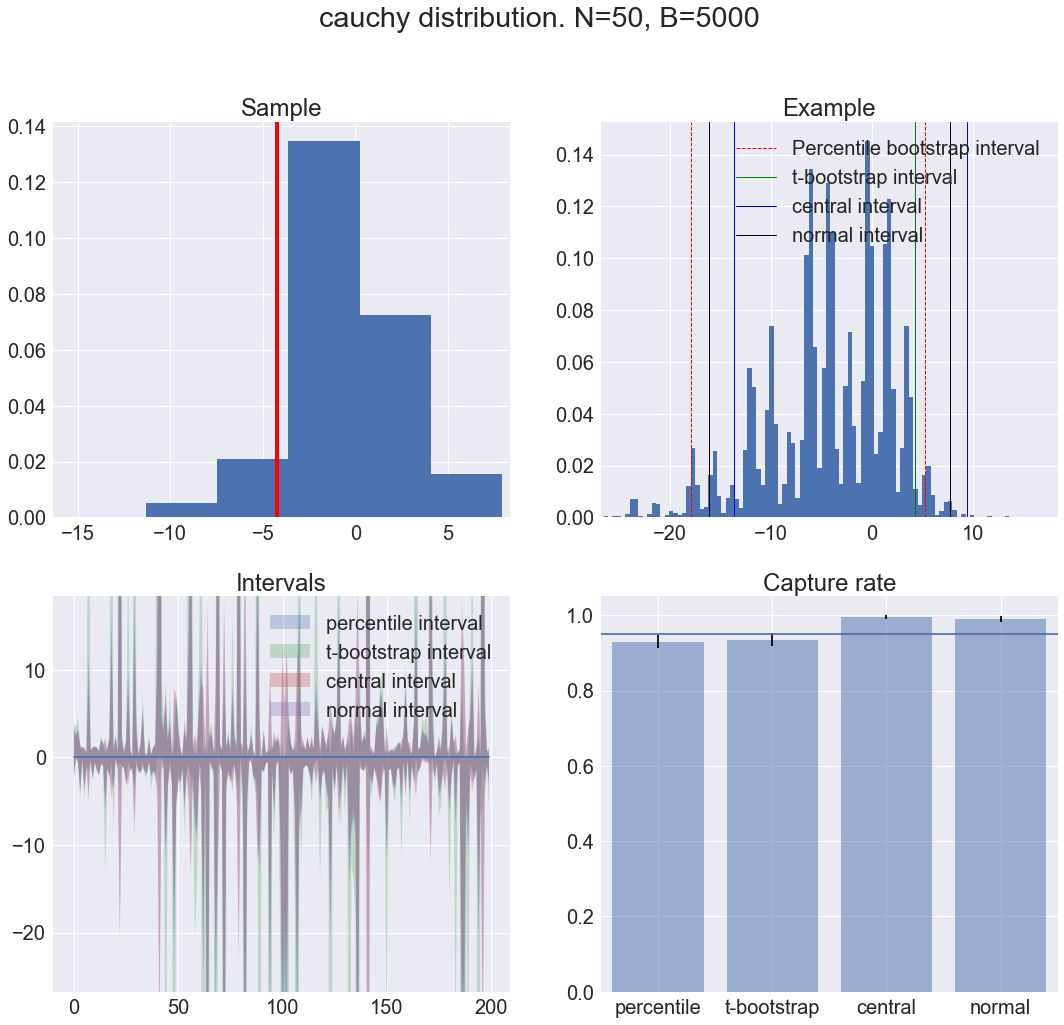

CPU times: user 2.46 s, sys: 955 ms, total: 3.41 s
Wall time: 2.07 s


In [19]:
%%time
plot_statistics(cauchy(), true_mean=0)

# Нормальное распределение

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/1080px-Normal_Distribution_PDF.svg.png" alt="drawing" width="400"/>

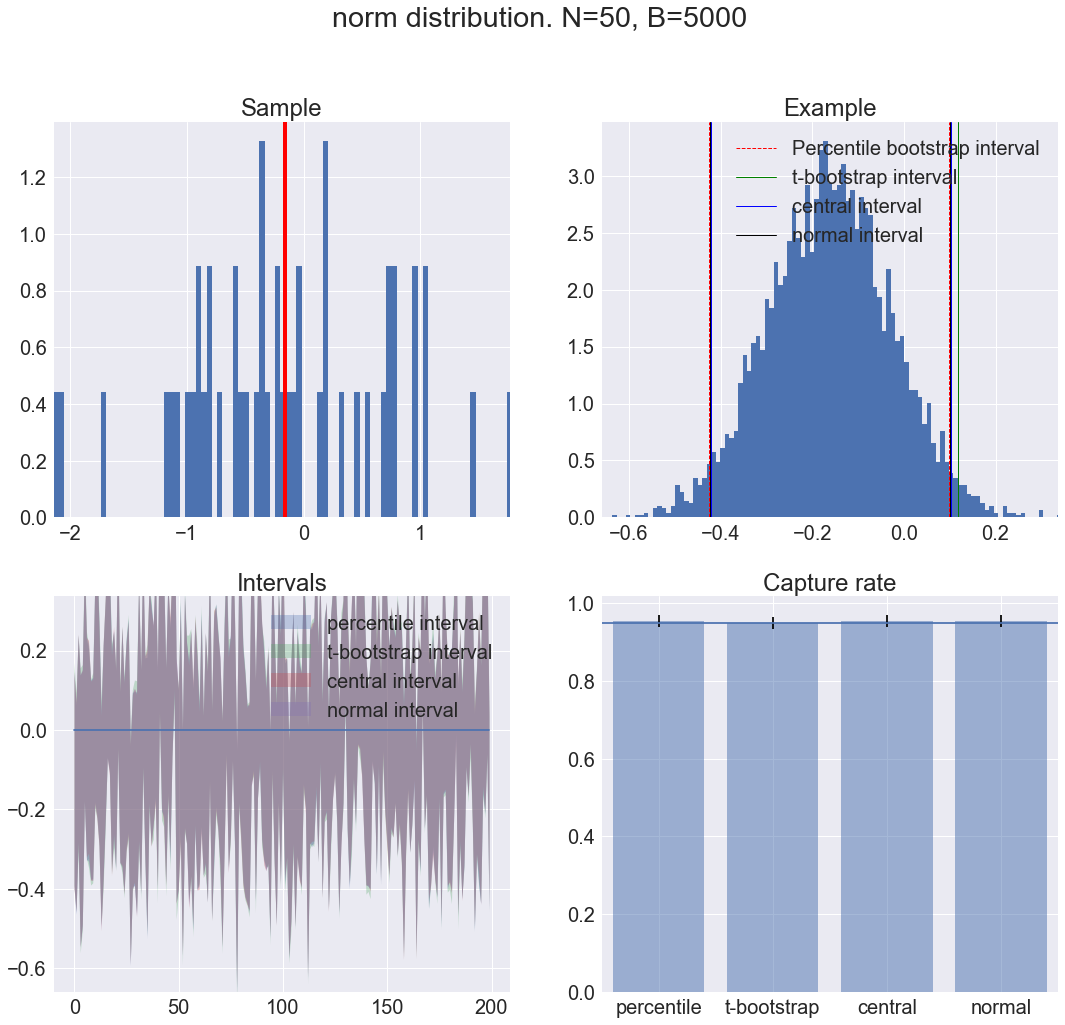

In [24]:
N = 50
plot_statistics(norm(), true_mean=0)

# Экспоненциальное распределение

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/360px-Exponential_pdf.svg.png" alt="drawing" width="400"/>

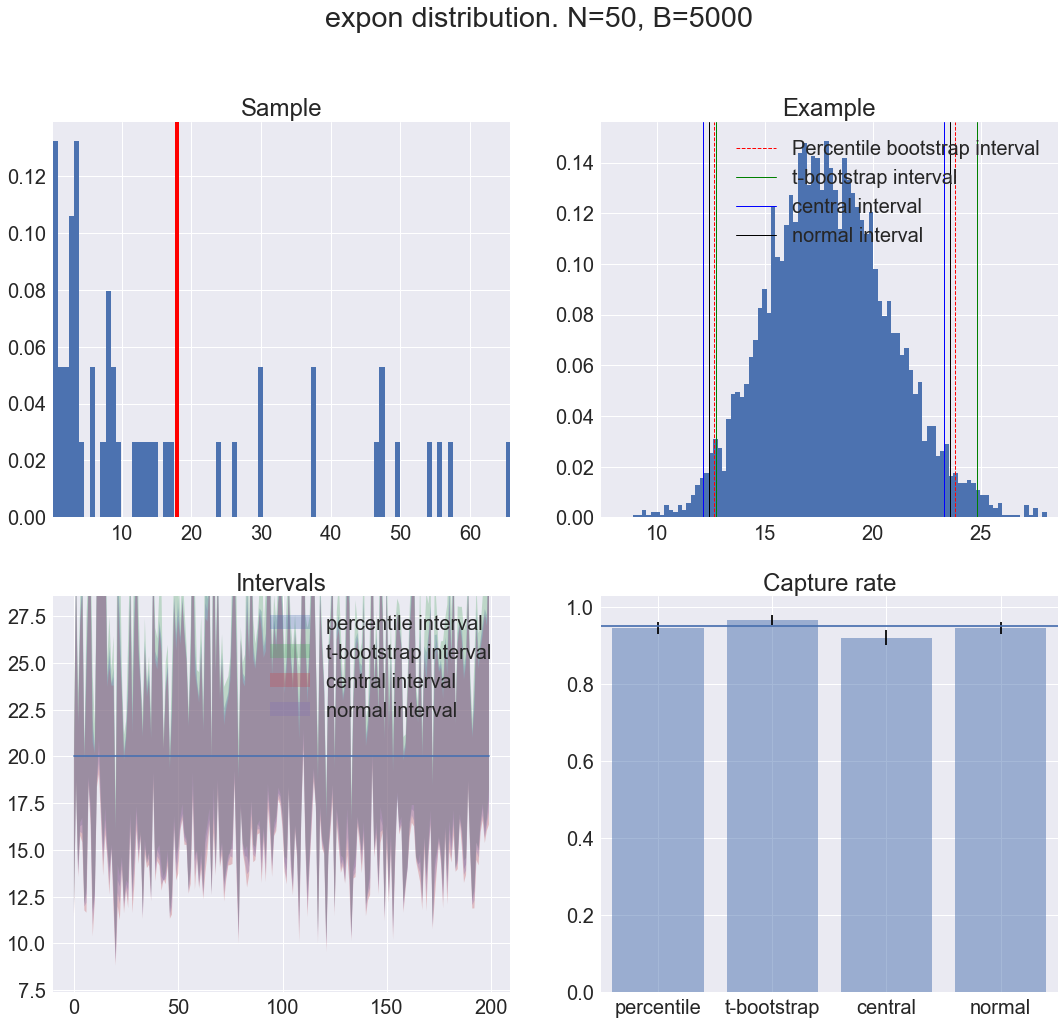

In [30]:
lam = 20
plot_statistics(expon(scale=lam), true_mean=lam)



# Бета распределение

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Beta_distribution_pdf.png/1024px-Beta_distribution_pdf.png" alt="drawing" width="400"/>

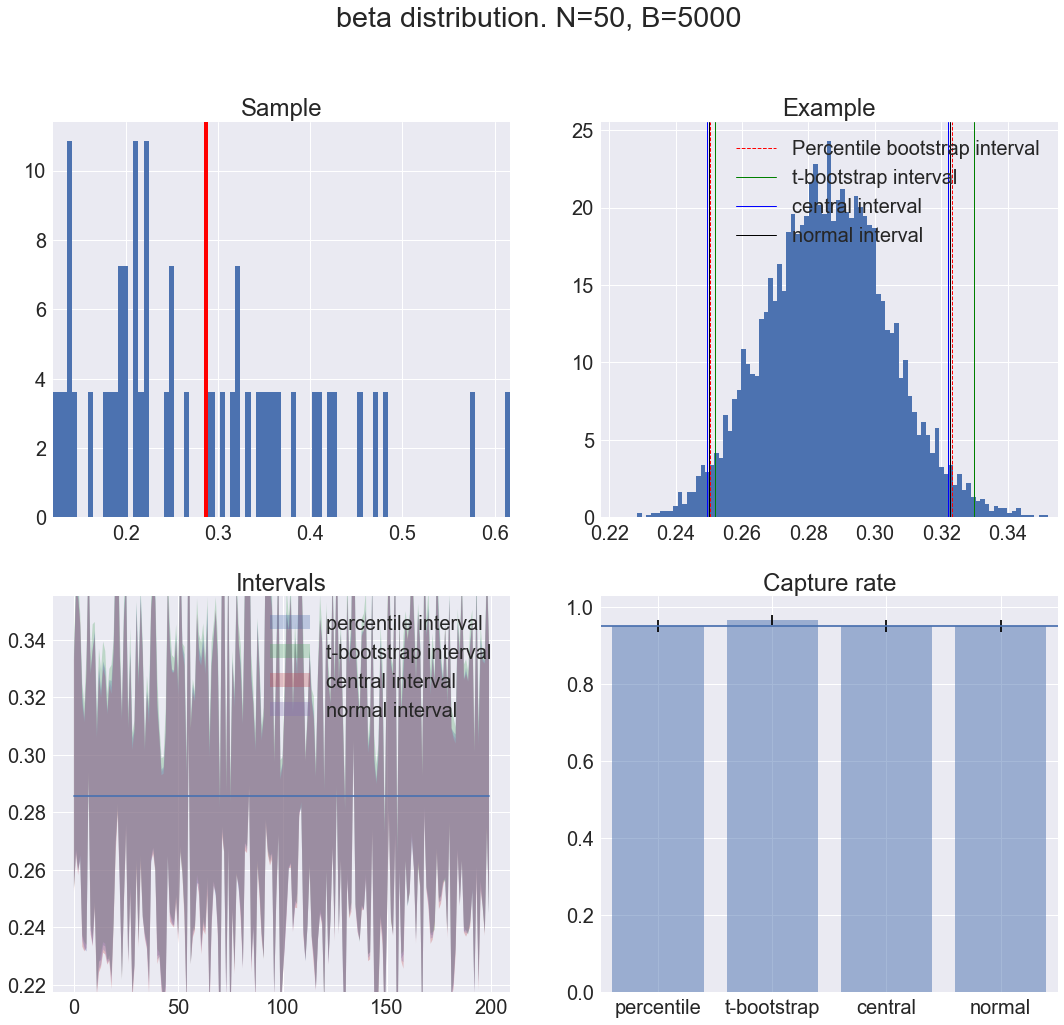

In [28]:
plot_statistics(beta(a=2, b=5), true_mean=2 / (2 + 5))

#### Выводы

Как видно, `t-bootstrap` показывает более хорошее качество в случае с не симметричными распределениями. Этого и стоило ожидать, так как, вообще говоря, он относится к методам второго порядка класса pivotal(пивотальных) бутстрапов.

![](bootstraps.jpg)